In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
DATA_PATH = os.path.join("..", "data", "a2", "data")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")
FOLDERS = os.listdir(TRAIN_PATH)

In [3]:
DATASET = []

for folder in FOLDERS:
    for file in os.listdir(os.path.join(TRAIN_PATH, folder)):
        DATASET.append({"label": folder, "img_name": file})

DATASET = np.array(DATASET)
DATASET.shape

(1500,)

In [4]:
def get_data(dataset, img_size=(32, 32), path=TRAIN_PATH):
    X = []
    y = []
    for data in dataset:
        img = cv2.imread(os.path.join(path, data["label"], data["img_name"]))
        img = cv2.resize(img, img_size)
        X.append(img.flatten())
        y.append(data["label"])
    return np.array(X), np.array(y)

In [5]:
X, y = get_data(DATASET, img_size=(128, 128), path=TRAIN_PATH)
X.shape, y.shape

((1500, 49152), (1500,))

In [6]:
def get_histograms(X):
    histograms = []
    for img in tqdm(X):
        img = img.reshape(128, 128, 3)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist)
        histograms.append(hist.flatten())
    return np.array(histograms)

In [7]:
X = get_histograms(X)
X.shape

100%|██████████| 1500/1500 [00:00<00:00, 14285.74it/s]


(1500, 512)

In [9]:
# Splitting the data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 512), (300, 512), (1200,), (300,))

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [11]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
classification_reports = []

In [12]:
for kernel in (t := tqdm(kernels, desc="Training", total=len(kernels))):
    t.set_postfix({"kernel": kernel})
    clf = SVC(kernel=kernel)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    rep = classification_report(y_val, y_pred)
    classification_reports.append({"kernel": kernel, "report": rep})

Training: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, kernel=sigmoid]


In [13]:
for report in classification_reports:
    print(report["kernel"])
    print(report["report"])

linear
              precision    recall  f1-score   support

       Coast       0.00      0.00      0.00        15
      Forest       0.23      0.43      0.30        21
     Highway       0.34      0.55      0.42        20
  Insidecity       0.00      0.00      0.00        17
    Mountain       0.08      0.07      0.07        15
      Office       0.18      0.15      0.16        20
 OpenCountry       0.00      0.00      0.00        22
      Street       0.64      0.38      0.47        24
      Suburb       0.41      0.71      0.52        21
TallBuilding       0.14      0.16      0.15        19
     bedroom       0.17      0.05      0.08        20
  industrial       0.38      0.21      0.27        28
     kitchen       0.06      0.13      0.09        15
  livingroom       0.00      0.00      0.00        19
       store       0.33      0.54      0.41        24

    accuracy                           0.24       300
   macro avg       0.20      0.23      0.20       300
weighted avg       

In [14]:
clf = SVC(kernel="rbf")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

       Coast       0.11      0.07      0.08        15
      Forest       0.25      0.52      0.34        21
     Highway       0.48      0.65      0.55        20
  Insidecity       0.09      0.12      0.10        17
    Mountain       0.12      0.13      0.12        15
      Office       0.29      0.25      0.27        20
 OpenCountry       0.33      0.05      0.08        22
      Street       0.59      0.42      0.49        24
      Suburb       0.42      0.62      0.50        21
TallBuilding       0.30      0.16      0.21        19
     bedroom       0.32      0.30      0.31        20
  industrial       0.25      0.14      0.18        28
     kitchen       0.03      0.07      0.04        15
  livingroom       0.14      0.05      0.08        19
       store       0.30      0.38      0.33        24

    accuracy                           0.27       300
   macro avg       0.27      0.26      0.25       300
wei

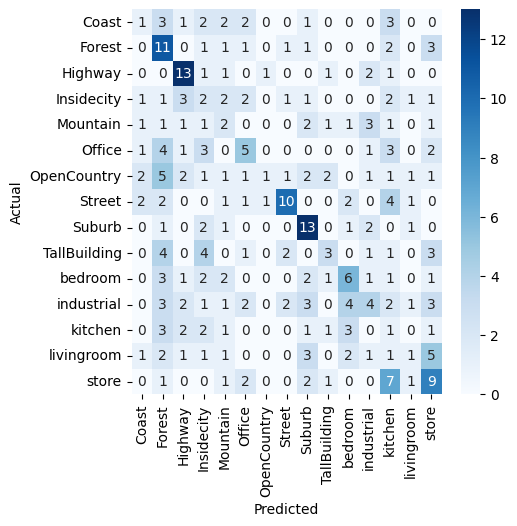

In [15]:
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
labels = np.unique(y_val)
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
TEST_DATASET = []

for folder in FOLDERS:
    for file in os.listdir(os.path.join(TEST_PATH, folder)):
        TEST_DATASET.append({"label": folder, "img_name": file})

TEST_DATASET = np.array(TEST_DATASET)
TEST_DATASET.shape

(2985,)

In [19]:
X_test, y_test = get_data(TEST_DATASET, img_size=(128, 128), path=TEST_PATH)
X_test.shape, y_test.shape

((2985, 49152), (2985,))

In [20]:
X_test = get_histograms(X_test)

100%|██████████| 2985/2985 [00:00<00:00, 14146.97it/s]


In [21]:
X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

       Coast       0.26      0.14      0.18       260
      Forest       0.20      0.34      0.25       228
     Highway       0.40      0.65      0.49       160
  Insidecity       0.20      0.27      0.23       208
    Mountain       0.25      0.21      0.23       274
      Office       0.17      0.26      0.21       115
 OpenCountry       0.46      0.07      0.12       310
      Street       0.48      0.38      0.42       192
      Suburb       0.30      0.52      0.38       141
TallBuilding       0.27      0.10      0.15       256
     bedroom       0.15      0.23      0.18       116
  industrial       0.24      0.18      0.20       211
     kitchen       0.15      0.33      0.20       110
  livingroom       0.17      0.04      0.07       189
       store       0.32      0.49      0.39       215

    accuracy                           0.26      2985
   macro avg       0.27      0.28      0.25      2985
wei

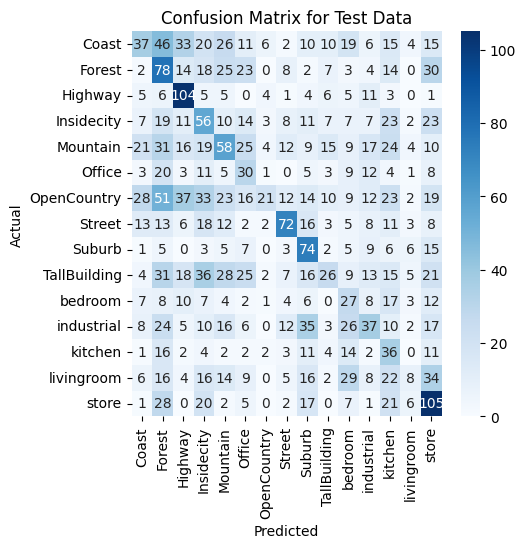

In [22]:
plt.figure(figsize=(5, 5))
labels = np.unique(y_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Test Data")
plt.show()